Found 6355 images belonging to 15 classes.
Found 270 images belonging to 15 classes.
Epoch 1/50
199/199 [==============================] - 95s 454ms/step - loss: 2.3505 - accuracy: 0.2307 - val_loss: 3.5656 - val_accuracy: 0.1074
Epoch 2/50
199/199 [==============================] - 90s 453ms/step - loss: 1.9812 - accuracy: 0.3114 - val_loss: 2.3803 - val_accuracy: 0.2222
Epoch 3/50
199/199 [==============================] - 88s 442ms/step - loss: 1.7770 - accuracy: 0.3800 - val_loss: 1.5173 - val_accuracy: 0.4556
Epoch 4/50
199/199 [==============================] - 90s 454ms/step - loss: 1.5810 - accuracy: 0.4469 - val_loss: 1.9873 - val_accuracy: 0.3667
Epoch 5/50
199/199 [==============================] - 91s 455ms/step - loss: 1.4944 - accuracy: 0.4675 - val_loss: 2.6304 - val_accuracy: 0.2593
Epoch 6/50
199/199 [==============================] - 88s 442ms/step - loss: 1.3100 - accuracy: 0.5312 - val_loss: 1.7472 - val_accuracy: 0.4333
Epoch 7/50
199/199 [=========================

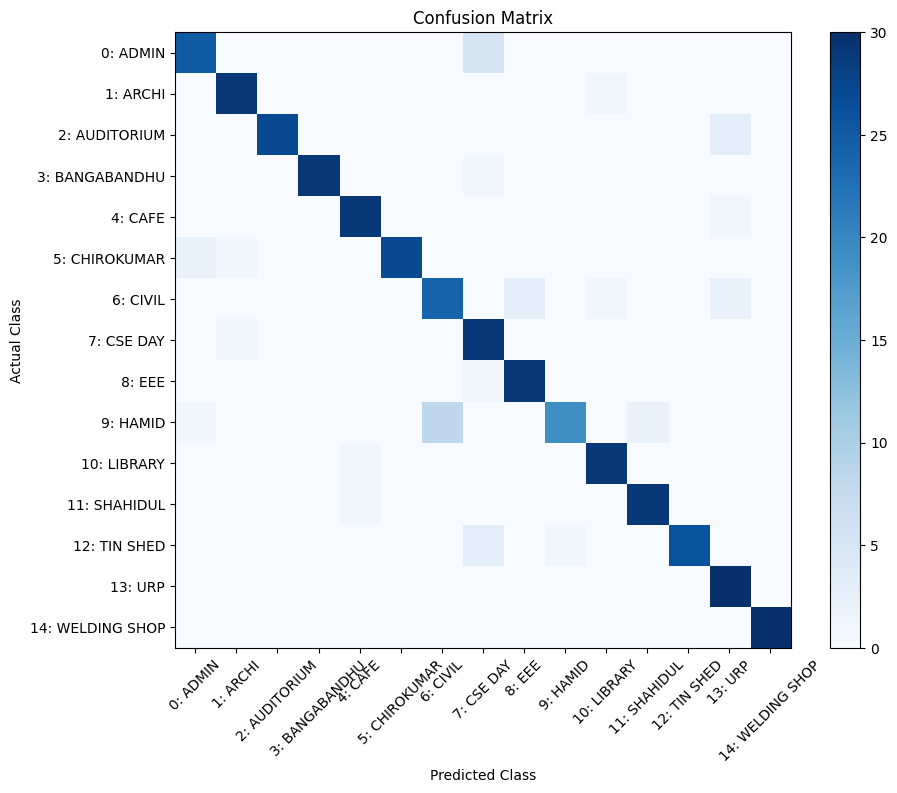

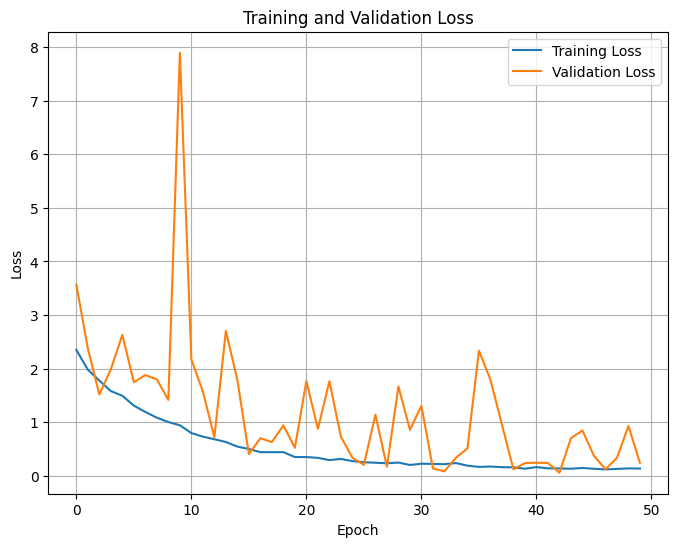

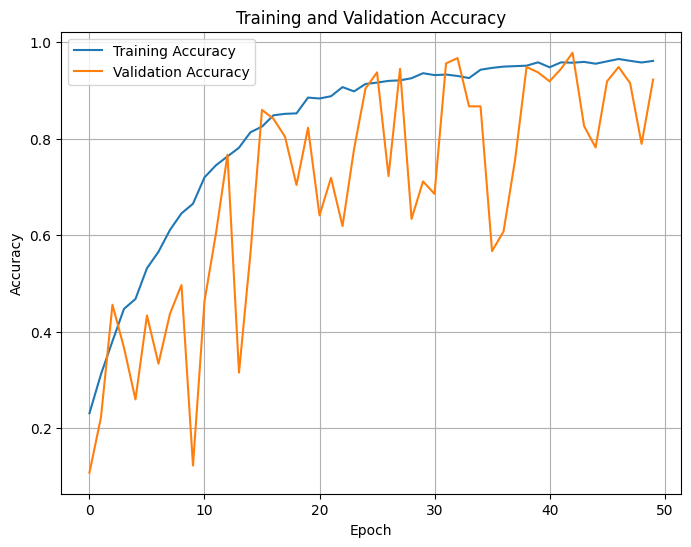

In [2]:
#"Model Training"

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/kaggle/input/dataset-ruet/basedata/basedata/training', target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_generator = valid_datagen.flow_from_directory('/kaggle/input/dataset-ruet/basedata/basedata/validation', target_size=(224, 224), batch_size=32, class_mode='categorical')


input_layer = Input(shape=(224, 224, 3))
x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(256, (5, 5), activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(384, (3, 3), activation='relu')(x)
x = Conv2D(384, (3, 3), activation='relu')(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
output_layer = Dense(15, activation='softmax')(x)


model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator, epochs=50, validation_data=valid_generator)
model.save('custom_alexnet_model.h5')

test_data_dir = '/kaggle/input/dataset-ruet/basedata/basedata/testing'
test_images = []
ground_truth_labels = []
for class_name in os.listdir(test_data_dir):
    class_dir = os.path.join(test_data_dir, class_name)
    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array /= 255.0
        test_images.append(img_array)
        ground_truth_labels.append(class_name)


test_images = np.array(test_images)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)


label_to_index = {label: i for i, label in enumerate(train_generator.class_indices)}
ground_truth_indices = np.array([label_to_index[label] for label in ground_truth_labels])


class_names = list(train_generator.class_indices.keys())
class_numbers = [label_to_index[label] for label in class_names]

conf_matrix = confusion_matrix(ground_truth_indices, predicted_labels)

accuracy = accuracy_score(ground_truth_indices, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
tick_marks = np.arange(len(train_generator.class_indices))
plt.xticks(tick_marks, [f"{class_numbers[i]}: {class_names[i]}" for i in tick_marks], rotation=45)
plt.yticks(tick_marks, [f"{class_numbers[i]}: {class_names[i]}" for i in tick_marks])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid()
plt.show()


In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score

num_classes = conf_matrix.shape[0]

precisions = []
recalls = []
f1_scores = []

for i in range(num_classes):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    

    if precision == 0 and recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

print("Class Precisions:", precisions)
print("Class Recalls:", recalls)
print("Class F1 Scores:", f1_scores)

from sklearn.metrics import precision_score, recall_score, f1_score

micro_precision = precision_score(ground_truth_indices, predicted_labels, average='micro')
micro_recall = recall_score(ground_truth_indices, predicted_labels, average='micro')
micro_f1 = f1_score(ground_truth_indices, predicted_labels, average='micro')
print("Micro-Precision:", micro_precision)
print("Micro-Recall:", micro_recall)
print("Micro-F1:", micro_f1)



top_1_accuracy = accuracy_score(ground_truth_indices, predicted_labels)


top_5_predictions = np.argsort(predictions, axis=1)[:, -5:]
top_5_accuracy = np.mean(np.array([ground_truth_indices[i] in top_5_predictions[i] for i in range(len(ground_truth_indices))]))

print("Top-1 Accuracy:", top_1_accuracy)
print("Top-5 Accuracy:", top_5_accuracy)


Class Precisions: [0.8928571428571429, 0.9354838709677419, 1.0, 1.0, 0.9354838709677419, 1.0, 0.75, 0.7435897435897436, 0.90625, 0.95, 0.9354838709677419, 0.9354838709677419, 1.0, 0.8333333333333334, 1.0]
Class Recalls: [0.8333333333333334, 0.9666666666666667, 0.9, 0.9666666666666667, 0.9666666666666667, 0.9, 0.8, 0.9666666666666667, 0.9666666666666667, 0.6333333333333333, 0.9666666666666667, 0.9666666666666667, 0.8666666666666667, 1.0, 1.0]
Class F1 Scores: [0.8620689655172413, 0.9508196721311476, 0.9473684210526316, 0.983050847457627, 0.9508196721311476, 0.9473684210526316, 0.7741935483870969, 0.8405797101449275, 0.9354838709677419, 0.7599999999999999, 0.9508196721311476, 0.9508196721311476, 0.9285714285714286, 0.9090909090909091, 1.0]
Micro-Precision: 0.9133333333333333
Micro-Recall: 0.9133333333333333
Micro-F1: 0.9133333333333333
Top-1 Accuracy: 0.9133333333333333
Top-5 Accuracy: 1.0


In [1]:
#"Testing/Prediction"

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/kaggle/input/dataset-ruet/basedata/basedata/training', target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_generator = valid_datagen.flow_from_directory('/kaggle/input/dataset-ruet/basedata/basedata/validation', target_size=(224, 224), batch_size=32, class_mode='categorical')


input_layer = Input(shape=(224, 224, 3))
x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(256, (5, 5), activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(384, (3, 3), activation='relu')(x)
x = Conv2D(384, (3, 3), activation='relu')(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
output_layer = Dense(15, activation='softmax')(x)


model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.load_weights('/kaggle/working/custom_alexnet_model.h5')


import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score
import os


test_data_dir = '/kaggle/input/dataset-ruet/basedata/basedata/testing'
test_images = []
ground_truth_labels = []
for class_name in os.listdir(test_data_dir):
    class_dir = os.path.join(test_data_dir, class_name)
    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array /= 255.0
        test_images.append(img_array)
        ground_truth_labels.append(class_name)


test_images = np.array(test_images)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

label_to_index = {label: i for i, label in enumerate(train_generator.class_indices)}
ground_truth_indices = np.array([label_to_index[label] for label in ground_truth_labels])

class_names = list(train_generator.class_indices.keys())
class_numbers = [label_to_index[label] for label in class_names]

conf_matrix = confusion_matrix(ground_truth_indices, predicted_labels)

accuracy = accuracy_score(ground_truth_indices, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

top_1_accuracy = accuracy_score(ground_truth_indices, predicted_labels)
top_5_predictions = np.argsort(predictions, axis=1)[:, -5:]
top_5_accuracy = np.mean(np.array([ground_truth_indices[i] in top_5_predictions[i] for i in range(len(ground_truth_indices))]))


print("Accuracy:", accuracy)
print("Top-1 Accuracy:", top_1_accuracy)
print("Top-5 Accuracy:", top_5_accuracy)


Found 6355 images belonging to 15 classes.
Found 270 images belonging to 15 classes.
15/15 [==============================] - 5s 21ms/step
Confusion Matrix:
[[25  0  0  0  0  0  0  5  0  0  0  0  0  0  0]
 [ 0 29  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0 27  0  0  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0 29  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 29  0  0  0  0  0  0  0  0  1  0]
 [ 2  1  0  0  0 27  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 24  0  3  0  1  0  0  2  0]
 [ 0  1  0  0  0  0  0 29  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 29  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  8  0  0 19  0  2  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0 29  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0 29  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  1  0  0 26  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 30]]
Accuracy: 0.9133333333333333
Top-1 Accuracy: 0.9133333333333333
Top-5 Accuracy: 1.0


In [2]:
#"Performance Matrix Calculation"

from sklearn.metrics import confusion_matrix, accuracy_score
num_classes = conf_matrix.shape[0]

class_metrics = []
precisions = []
recalls = []
f1_scores = []
accuracies = []

for i in range(num_classes):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives


    true_negatives = np.sum(conf_matrix) - true_positives - false_positives - false_negatives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
   

    if precision == 0 and recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    accuracy = (true_positives + true_negatives) / np.sum(conf_matrix)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)


    class_metrics.append({
        'Class': i + 1,
        'True Positives': true_positives,
        'True Negatives': true_negatives,
        'False Positives': false_positives,
        'False Negatives': false_negatives,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    })


average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_f1_score = sum(f1_scores) / len(f1_scores)
average_accuracy = sum(accuracies) / len(accuracies)

print("Class Metrics:")
for metrics in class_metrics:
    print(f"Class {metrics['Class']} - Precision: {metrics['Precision']}, Recall: {metrics['Recall']}, F1 Score: {metrics['F1 Score']}, Accuracy: {metrics['Accuracy']}")
    print(f"TTP: {metrics['True Positives']}, TTN: {metrics['True Negatives']}, TFP: {metrics['False Positives']}, TFN: {metrics['False Negatives']}")
    print("")

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 Score:", average_f1_score)
print("Average Accuracy:", average_accuracy)


Class Metrics:
Class 1 - Precision: 0.8928571428571429, Recall: 0.8333333333333334, F1 Score: 0.8620689655172413, Accuracy: 0.9822222222222222
TTP: 25, TTN: 417, TFP: 3, TFN: 5

Class 2 - Precision: 0.9354838709677419, Recall: 0.9666666666666667, F1 Score: 0.9508196721311476, Accuracy: 0.9933333333333333
TTP: 29, TTN: 418, TFP: 2, TFN: 1

Class 3 - Precision: 1.0, Recall: 0.9, F1 Score: 0.9473684210526316, Accuracy: 0.9933333333333333
TTP: 27, TTN: 420, TFP: 0, TFN: 3

Class 4 - Precision: 1.0, Recall: 0.9666666666666667, F1 Score: 0.983050847457627, Accuracy: 0.9977777777777778
TTP: 29, TTN: 420, TFP: 0, TFN: 1

Class 5 - Precision: 0.9354838709677419, Recall: 0.9666666666666667, F1 Score: 0.9508196721311476, Accuracy: 0.9933333333333333
TTP: 29, TTN: 418, TFP: 2, TFN: 1

Class 6 - Precision: 1.0, Recall: 0.9, F1 Score: 0.9473684210526316, Accuracy: 0.9933333333333333
TTP: 27, TTN: 420, TFP: 0, TFN: 3

Class 7 - Precision: 0.75, Recall: 0.8, F1 Score: 0.7741935483870969, Accuracy: 0.9

In [3]:
#"Results Visualization"

import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

num_classes = conf_matrix.shape[0]

class_names = [
    'ADMIN', 'ARCHI', 'AUDITORIUM', 'BANGABANDHU', 'CAFE',
    'CHIROKUMAR', 'CIVIL', 'CSE DAY', 'EEE', 'HAMID',
    'LIBRARY', 'SHAHIDUL', 'TIN SHED', 'URP', 'WELDING SHOP'
]

class_metrics = []
precisions = []
recalls = []
f1_scores = []
accuracies = []

for i in range(num_classes):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    true_negatives = np.sum(conf_matrix) - true_positives - false_positives - false_negatives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
   
    if precision == 0 and recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    accuracy = (true_positives + true_negatives) / np.sum(conf_matrix)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)

    class_metrics.append({
        'Class': class_names[i],
        'TTP': true_positives,
        'TTN': true_negatives,
        'TFP': false_positives,
        'TFN': false_negatives,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    })

average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_f1_score = sum(f1_scores) / len(f1_scores)
average_accuracy = sum(accuracies) / len(accuracies)

class_metrics.append({
    'Class': 'Average',
    'TTP': '',w
    'TTN': '',
    'TFP': '',
    'TFN': '',
    'Precision': average_precision,
    'Recall': average_recall,
    'F1 Score': average_f1_score,
    'Accuracy': average_accuracy
})

metrics_df = pd.DataFrame(class_metrics)

metrics_df = metrics_df[['Class', 'TTP', 'TTN', 'TFP', 'TFN', 'Precision', 'Recall', 'F1 Score', 'Accuracy']]

print(metrics_df)


           Class TTP  TTN TFP TFN  Precision    Recall  F1 Score  Accuracy
0          ADMIN  25  417   3   5   0.892857  0.833333  0.862069  0.982222
1          ARCHI  29  418   2   1   0.935484  0.966667  0.950820  0.993333
2     AUDITORIUM  27  420   0   3   1.000000  0.900000  0.947368  0.993333
3    BANGABANDHU  29  420   0   1   1.000000  0.966667  0.983051  0.997778
4           CAFE  29  418   2   1   0.935484  0.966667  0.950820  0.993333
5     CHIROKUMAR  27  420   0   3   1.000000  0.900000  0.947368  0.993333
6          CIVIL  24  412   8   6   0.750000  0.800000  0.774194  0.968889
7        CSE DAY  29  410  10   1   0.743590  0.966667  0.840580  0.975556
8            EEE  29  417   3   1   0.906250  0.966667  0.935484  0.991111
9          HAMID  19  419   1  11   0.950000  0.633333  0.760000  0.973333
10       LIBRARY  29  418   2   1   0.935484  0.966667  0.950820  0.993333
11      SHAHIDUL  29  418   2   1   0.935484  0.966667  0.950820  0.993333
12      TIN SHED  26  420